In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Random forest
from sklearn.ensemble import RandomForestClassifier

# MLP
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

# Xgboost
import xgboost as xgb

# KAN
import torch
from kan import KAN

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score
import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

### Funções úteis

In [2]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [49]:
def plot_multiple_roc_curves(models: list) -> None:
    plt.figure()
    
    for (y_pred, y_test, label) in models:
        # Obter as probabilidades da classe positiva
        y_pred_positive = y_pred[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
        roc_auc = roc_auc_score(y_test, y_pred_positive)

        plt.plot(fpr, tpr, lw=2, label=f'ROC curve {label} (area = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparative ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

### Carregando o dataset

In [4]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [5]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [6]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [7]:
df_train_str = one_hot_to_string(df=df_train, col=columns_to_concat)
df_val_str = one_hot_to_string(df=df_val, col=columns_to_concat)
df_test_str = one_hot_to_string(df=df_test, col=columns_to_concat)

In [8]:
X_train = df_train.drop(['satisfaction'], axis=1).values
X_train_str = df_train_str.drop(['satisfaction'], axis=1).values
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1).values
X_val_str = df_val_str.drop(['satisfaction'], axis=1).values
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1).values
X_test_str = df_test_str.drop(['satisfaction'], axis=1).values
y_test = df_test['satisfaction'].values

In [9]:
X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Random Forest

In [10]:
rf_model = RandomForestClassifier(
    n_estimators=480,
    max_depth=18,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=51
)

In [11]:
rf_model.fit(X=X_train_str, y=y_train)

RandomForestClassifier(max_depth=18, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=480, random_state=51)

In [12]:
y_pred_rf = rf_model.predict(X_test_str)
y_pred_rf_scores = rf_model.predict_proba(X_test_str)

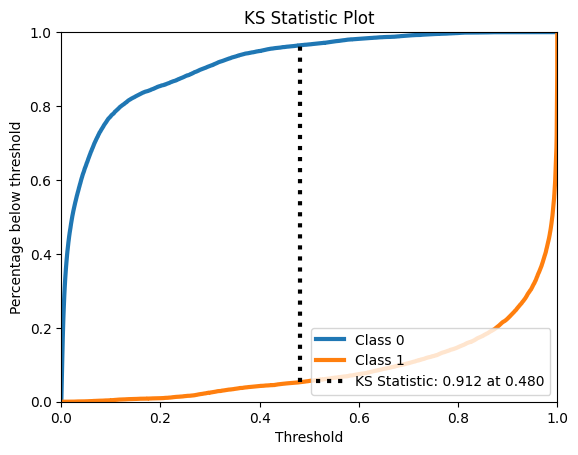

In [13]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_rf, y_pred_rf_scores)

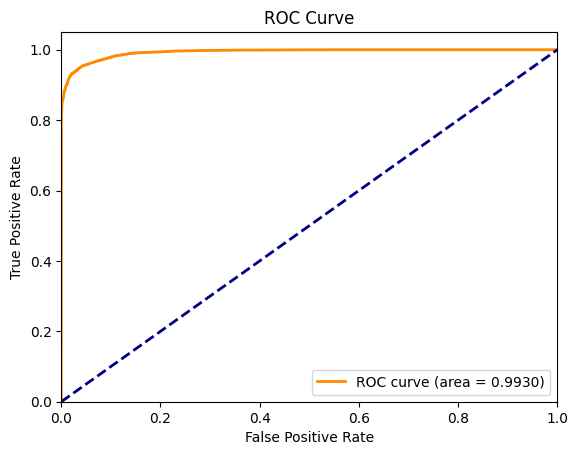

In [14]:
plot_roc_curve(y_pred_rf_scores, y_test)

# MLP

In [15]:
keras.utils.set_random_seed(42)

In [16]:
mlp_model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(136, activation='relu'),
    Dropout(0.1),

    Dense(136, activation='relu'),
    Dropout(0.1),
    
    Dense(136, activation='relu'),
    Dropout(0.1),
    
    Dense(136, activation='relu'),
    Dropout(0.1),

    # Output layer
    Dense(2, activation='softmax')
])

In [17]:
mlp_model.compile(
    optimizer='rmsprop', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [19]:
mlp_model.fit(
    X_train,
    y_train, 
    epochs=25, 
    batch_size=128, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6988 - loss: 0.8904 - val_accuracy: 0.7865 - val_loss: 0.4729
Epoch 2/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7940 - loss: 0.4566 - val_accuracy: 0.8453 - val_loss: 0.3625
Epoch 3/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8284 - loss: 0.3962 - val_accuracy: 0.8368 - val_loss: 0.4081
Epoch 4/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8420 - loss: 0.3742 - val_accuracy: 0.8445 - val_loss: 0.3839
Epoch 5/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8487 - loss: 0.3623 - val_accuracy: 0.8475 - val_loss: 0.3613
Epoch 6/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8592 - loss: 0.3430 - val_accuracy: 0.8761 - val_loss: 0.2945
Epoch 7/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8681 - loss: 0.3207 - val_accuracy: 0.8801 - val_loss: 0.3044
Epoch 8/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8787 - loss: 0.2936 - val_accuracy: 0.

In [20]:
y_pred_mlp_scores = mlp_model.predict(X_test)
y_pred_mlp = np.argmax(y_pred_mlp_scores, axis=1)

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step


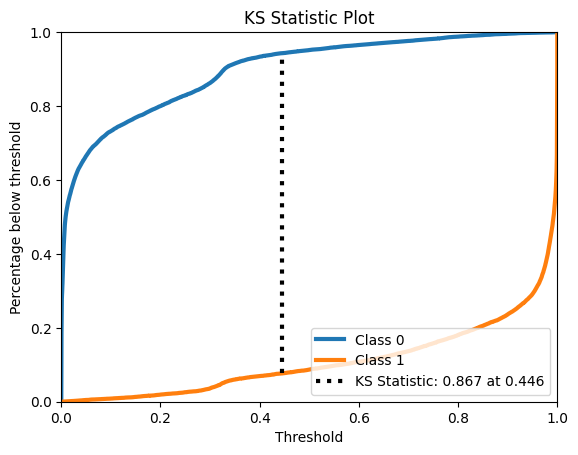

In [21]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_mlp, y_pred_mlp_scores)

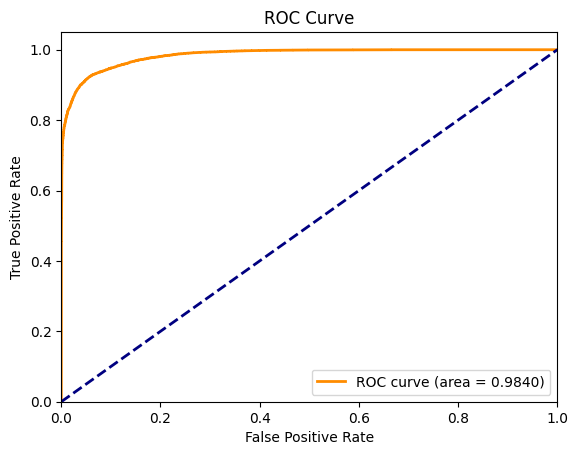

In [22]:
plot_roc_curve(y_pred_mlp_scores, y_test)

# XGBoost

In [23]:
dtrain = xgb.DMatrix(X_train_str, label=y_train)
dval = xgb.DMatrix(X_val_str, label=y_val)
dtest = xgb.DMatrix(X_test_str, label=y_test)

In [24]:
params = {
    'max_depth': 21,
    'eta': 0.2,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'lambda' : 1,
    'alpha' : 5,
    'grow_policy' : 'lossguide'
}

In [25]:
xgboost_model = xgb.train(params, dtrain, 100, evals=[(dval, 'validation')], early_stopping_rounds=5)

[0]	validation-auc:0.98791
[1]	validation-auc:0.98862
[2]	validation-auc:0.98976
[3]	validation-auc:0.98996
[4]	validation-auc:0.99046
[5]	validation-auc:0.99121
[6]	validation-auc:0.99148
[7]	validation-auc:0.99171
[8]	validation-auc:0.99201
[9]	validation-auc:0.99229
[10]	validation-auc:0.99266
[11]	validation-auc:0.99289
[12]	validation-auc:0.99305
[13]	validation-auc:0.99317
[14]	validation-auc:0.99327
[15]	validation-auc:0.99337
[16]	validation-auc:0.99347
[17]	validation-auc:0.99356
[18]	validation-auc:0.99364
[19]	validation-auc:0.99372
[20]	validation-auc:0.99375
[21]	validation-auc:0.99379
[22]	validation-auc:0.99384
[23]	validation-auc:0.99387
[24]	validation-auc:0.99392
[25]	validation-auc:0.99394
[26]	validation-auc:0.99400
[27]	validation-auc:0.99406
[28]	validation-auc:0.99411
[29]	validation-auc:0.99414
[30]	validation-auc:0.99417
[31]	validation-auc:0.99418
[32]	validation-auc:0.99421
[33]	validation-auc:0.99421
[34]	validation-auc:0.99423
[35]	validation-auc:0.99423
[3

In [26]:
y_pred_xgboost_scores = xgboost_model.predict(dtest)
neg_y_probs = 1 - y_pred_xgboost_scores

y_pred_xgboost_scores = np.vstack((neg_y_probs, y_pred_xgboost_scores)).T
y_pred_xgboost = np.argmax(y_pred_xgboost_scores, axis=1)

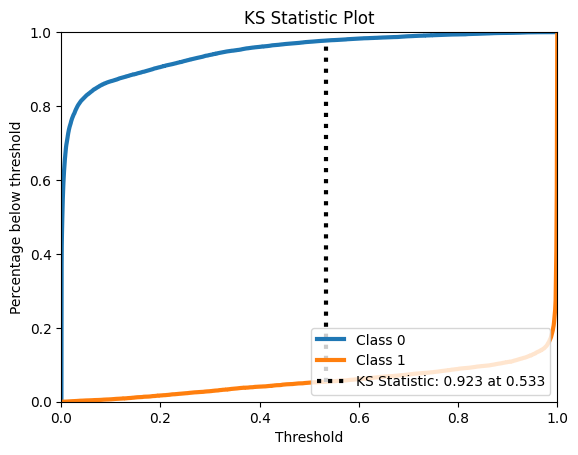

In [27]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_xgboost, y_pred_xgboost_scores)

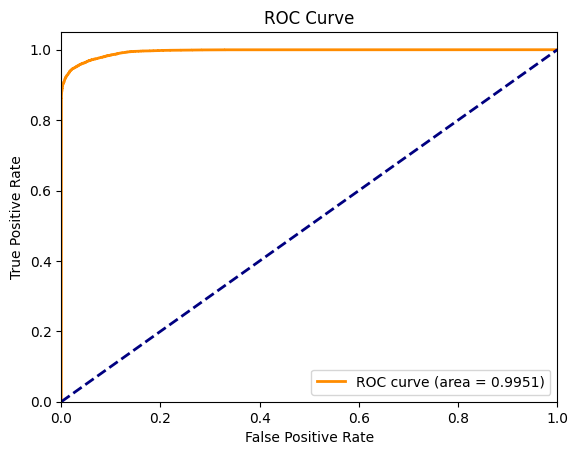

In [28]:
plot_roc_curve(y_pred_xgboost_scores, y_test)

# KAN

In [29]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)
test_input = torch.tensor(X_val, dtype=torch.float32)
test_label = torch.tensor(y_val, dtype=torch.long)

In [30]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

In [31]:
kan_model = KAN(width=[X_train.shape[1], 2], grid=3, k=3)

checkpoint directory created: ./model
saving model version 0.0


In [32]:
def train_acc():
    return torch.mean((torch.argmax(kan_model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(kan_model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [34]:
results = kan_model.fit(dataset, opt="LBFGS", steps=10, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

| train_loss: 4.60e-01 | test_loss: 4.62e-01 | reg: 0.00e+00 | : 100%|█| 10/10 [00:59<00:00,  5.91s/

saving model version 0.1


In [35]:
test_outputs = kan_model(dataset['test_input'])
y_pred_kan = torch.argmax(test_outputs, dim=1).numpy()
y_pred_kan_scores = torch.softmax(test_outputs, dim=1).detach().numpy()

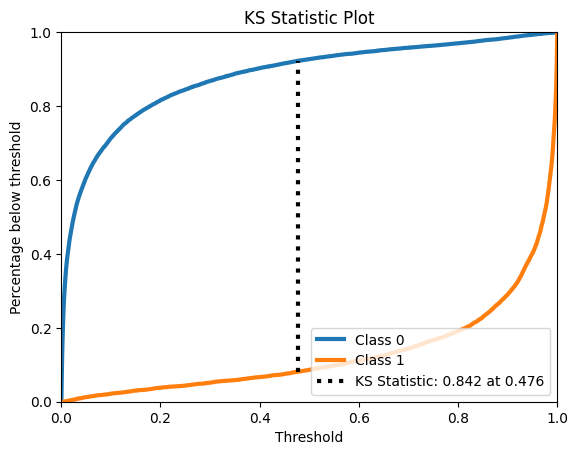

In [36]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(dataset['test_label'], y_pred_kan, y_pred_kan_scores)

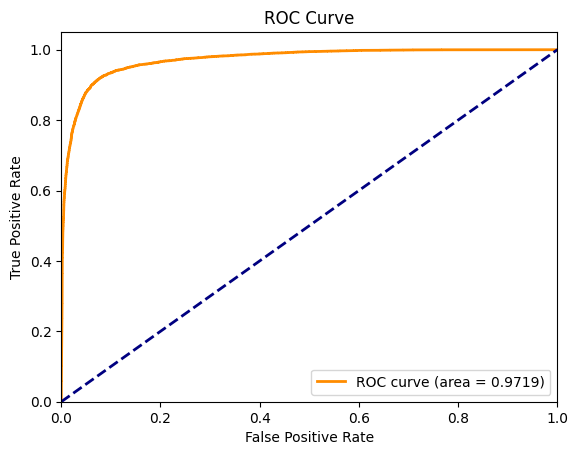

In [37]:
plot_roc_curve(y_pred_kan_scores, dataset['test_label'])

# Comparando resultados

In [47]:
models = [
    (y_pred_rf_scores, y_test, 'rf'),
    (y_pred_mlp_scores, y_test, 'mlp'),
    (y_pred_xgboost_scores, y_test, 'xgboost'),
    (y_pred_kan_scores, dataset['test_label'], 'kab')
]

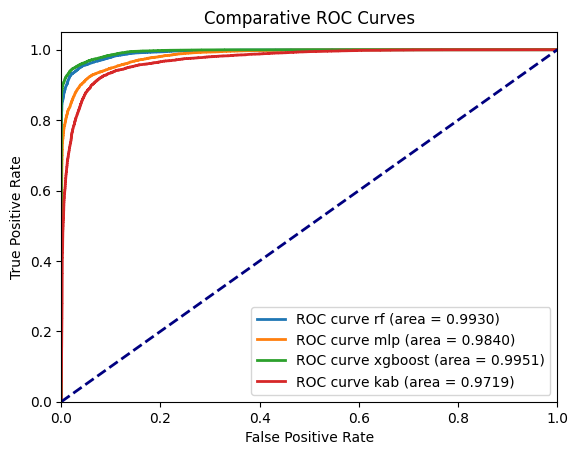

In [50]:
plot_multiple_roc_curves(models)